# Intro
9 projets "data science" sur 10 [ne finissent pas en production](https://towardsdatascience.com/why-90-percent-of-all-machine-learning-models-never-make-it-into-production-ce7e250d5a4a).  
Une des raisons est la difficulté ainsi que le manque de normes pour passer d'un notebook à un produit fonctionnel réellement utile.    
Dans ce tuto nous allons voir, à travers un cas simple, comment utiliser fastAPI pour créer une API permettant d'exposer des services IA, qui pourra ensuite être requetée depuis n'importe quelle brique logicielle, en HTTP.   
Plus précisement, nous allons ici récupérer des données d'utilisations d'un logiciel présent sur un parc de machines, stockées dans elasticsearch, que nous allons raffiner afin d'en extraire des sessions (clustering selon l'axe du temps uniquement).

# Qu'est ce que FastAPI ?
D'après la [tres bonne doc officielle](https://fastapi.tiangolo.com/), FastAPI est "un framework web moderne, rapide pour construire des APIs python 3.7+ se basant sur les indices de typage standard python".  
Il est rapide (comparable à go et NodeJS), permet de developper rapidement, simple, et fourni plusieurs d'outils assez pratiques.

# Pourquoi FastAPI plutot que d'autres web servers ?

- bien plus léger que [Django Rest Framework](https://www.django-rest-framework.org/)
- plus performant que [flask](https://flask.palletsprojects.com/en/2.2.x/), profite du typage pour la doc et la validation automatique de la donnée d'entrée via [pydantic](https://pydantic-docs.helpmanual.io/).
- rajoute des utilitaires pratiques au dessus de [starlette](https://www.starlette.io/).

# Création de l'environnement virtuel

```bash
poetry init 
poetry add pandas fastapi[all] elasticsearch[async]==7.13 requests pyYAML
```

L'arborescence du projet est alors:
```
tp_fast_api/   
├── .venv/
├── poetry.lock
└── pyproject.toml
```
# Squelette de base 


In [ ]:
from fastapi import FastAPI

app = FastAPI(debug=True)

@app.post("/get_ecrans/") # on fait un post pour simplifier l'envoi de données: dans le body directement
def get_ecrans(): 
    return {"ecrans": ["ecran1", "ecran2"]}

Lancer le serveur web avec guvicorn, apres avoir lancé l'environnement virtuel:
```bash
poetry shell
uvicorn tp_fast_api.main:app --reload
```
Puis aller sur http://127.0.0.1:8000/docs

# Ajout des parametres
On va maintenant ajouter des parametres: l'utilisateur sur lequel on veut requeter, une date min et une date max:

In [ ]:
# main.py
from datetime import datetime

from fastapi import FastAPI
from pydantic import BaseModel

from tp_fast_api.data_collect import extract_ecrans


class Users(BaseModel):
    utils: list[str]
    date_min: datetime
    date_max: datetime


app = FastAPI(debug=True)


@app.post("/get_ecrans/")
def get_ecrans(users: Users):
    return {"ecrans": ["ecran1", "ecran2"], "users": users.utils}

On a utilisé pour cela [pydantic](https://pydantic-docs.helpmanual.io/).  
Essayer d'envoyer le body suivant:
```
{
 "utils": ["romain"],
 "date_min": "2022-09-22 11:00Z",
 "date_max": "2022-09-28T12:00+02:00"
}
```
On obtient un 200:
```json
{
  "ecrans": [
    "ecran1",
    "ecran2"
  ],
  "users": {
    "utils": [
      "romain"
    ],
    "date_min": "2022-09-22T11:00:00+00:00",
    "date_max": "2022-09-28T12:00:00+02:00"
  }
}
```


On se rend compte que les dates ont été automatiquement parsées dans le bon type (bien que deux formats différents aient été envoyés)  
Pour la liste des types de date pris en charge par pydantic: https://pydantic-docs.helpmanual.io/usage/types/#datetime-types

Maintenant essayer de lancer avec une date dans un format inconnu, et "utils" mal écrit:
```
{
 "util": ["romain"],
 "date_min": "2022-09-22 11:00Z",
 "date_max": "2022-09-28 / 12:00+02:00"
}
```
On obtient un 422: 
```json
{
  "detail": [
    {
      "loc": [
        "body",
        "utils"
      ],
      "msg": "field required",
      "type": "value_error.missing"
    },
    {
      "loc": [
        "body",
        "date_max"
      ],
      "msg": "invalid datetime format",
      "type": "value_error.datetime"
    }
  ]
}
```
Avec uniquement ces quelques lignes en plus, on a:
- une lecture du body
- une convertion et validation de type
- une gestion des erreurs parlante en cas de probleme
- un support de l'IDE pour l'autocompletion du body d'entrée qu'on souhaite manipuler
- une documentation directe dans OpenAPI pour l'utilisateur

L'arborescence du projet est alors:
```
tp_fast_api/   
├── .venv/
├── poetry.lock
├── pyproject.toml
└── tp_fast_api/
    └── main.py
```

# Requetage sur elastic
On crée un dossier config/ à la racine, qui va contenir les credentials (en YAML). On y mettra tous les tokens et clés qui ne doivent pas être commit.
On y met notamment ici les tokens d'accès à elastic.

```yml
# credentials.yml
ES_PROD_ID: "<id>"
ES_PROD_API_KEY: "<api_key>"
```
On rajoute en suite un fichier settings.py permettant d'exposer les variables globales du projet, qui va se charger de créer la connexion à Elastic:

In [ ]:
# settings.py
import pathlib

import yaml
from elasticsearch import Elasticsearch

CREDENTIAL_PATH = pathlib.Path(__file__).parent.parent / "config" / "credentials.yml"

with open(CREDENTIAL_PATH, "r") as f:
    credentials = yaml.safe_load(f)

URL_ELASTIC_PROD = "<url_elastic>:9200"

ES_PROD = Elasticsearch(
    hosts=[URL_ELASTIC_PROD],
    request_timeout=30,
    api_key=(credentials["ES_PROD_ID"], credentials["ES_PROD_API_KEY"]),
)

On créé maintenant une fonction qui va aller directement chercher les données dans elastic, dans un module data_collect.py, à part:

In [ ]:
# data_collect.py
from datetime import datetime

from elasticsearch import helpers

import tp_fast_api.settings as settings


def extract_ecrans(utils: list[str], date_min: datetime, date_max: datetime) -> list[list[str]]:
    query = {
        "query": {
            "bool": {
                "must": [{"terms": {"util": utils}}],
                "filter": [
                    {
                        "range": {
                            "@timestamp": {
                                "gte": date_min.isoformat(),
                                "lte": date_max.isoformat(),
                                "format": "strict_date_optional_time",
                            }
                        }
                    }
                ],
            }
        }
    }

    data = []
    for doc in helpers.scan(settings.ES_PROD, index="<my_index>", query=query):
        doc = doc["_source"]

        elt = [
            doc.get("@timestamp"],
            doc.get("util"),
            doc.get("ecran"),
            doc.get("instance")
        ]
        data.append(elt)

    return data

Puis on met à jour le main pour retourner ces écrans:

In [ ]:
# main.py
from datetime import datetime

from fastapi import FastAPI
from pydantic import BaseModel

from tp_fast_api.data_collect import extract_ecrans


class Users(BaseModel):
    utils: list[str]
    date_min: datetime
    date_max: datetime


app = FastAPI(debug=True)


@app.post("/get_ecrans/")
def get_ecrans(users: Users):
    ecrans = extract_ecrans(users.utils, users.date_min, users.date_max)
    return {"users": users, "ecrans": ecrans}

On peut alors tester l'envoi de requete, et constater qu'on reçoit bien une liste d'écrans:
```json
{
  "ecrans": [
    [
      1663849892657,
      "romain",
      "connexion",
      "instance589",
    ],
    [...]
  ]
}
```

**NB**: le typage des dates s'est effectué automatiquement grâce à pydantic, ça nous a évité la gestion des convertions qui peut s'avérer pénible. 


L'arborescence est alors:

```
tp_fast_api
├── config
│   └── credentials.yml
├── poetry.lock        
├── pyproject.toml     
└── tp_fast_api
    ├── data_collect.py
    ├── main.py
    └── settings.py
```

# Tests
On va maintenant tester notre fonction. Pour cela, on va avoir besoin d'intercepter l'appel à elastic, et de mocker son resultat: l'environnement de test n'a pas forcément accès à elastic, et on ne veut rajouter de la charge potentielle sur le cluster à chaque requete.


On ajoute pytest:
```
poetry add pytest
```

Puis on ajoute le test unitaire:

In [ ]:
# test_data_collect.py
from datetime import datetime
from unittest.mock import patch

from tp_fast_api.data_collect import extract_ecrans


@patch("tp_fast_api.data_collect.helpers.scan")
def test_extract_ecrans(mock_scan):
    mock_scan.return_value = [
        {
            "_index": "mon_index",
            "_type": "_doc",
            "_id": "1660119206971bdcad61d5b",
            "_score": 2.0,
            "_source": {
                "ecran": "connexion",
                "instance": "instance589",
                "@timestamp": 1660119206971,
                "util": "romain"
            },
        }
    ]

    # les parametres ici ne sont pas tres important puisque on intercepte la requete
    results = extract_ecrans(["romain"], datetime.now(), datetime.now())

    assert len(results) == 1
    assert results[0][1] == "romain"

Arborescence:
```
tp_fast_api
├── config
│   └── credentials.yml
├── tests
│   ├── __init__.py
│   └── test_data_collect.py
├── tp_fast_api
│   ├── __init__.py
│   ├── data_collect.py
│   ├── main.py
│   └── settings.py
├── poetry.lock
└── pyproject.toml
```

On lance les tests, avec pytest:
```bash
pytest .
```
![](https://raw.githubusercontent.com/Romathonat/vulgaireDevEntries/master/fastAPI_for_IA/test100.png)
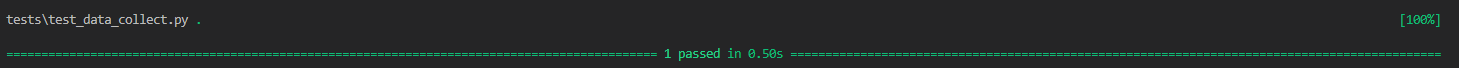

# Script de requetage
On va ecrire un code permettant de requeter à part notre service, afin notamment de faire un petit benchmark basique par la suite.
On lance 100 requetes en asynchrone, avec les mêmes parametres.

In [ ]:
import asyncio
import datetime
import time

import httpx


async def query_api():
    body = {
        "date_max": datetime.datetime.now().isoformat(),
        "date_min": (datetime.datetime.now() - datetime.timedelta(7)).isoformat(),
        "utils": ["util"],
    }
    async with httpx.AsyncClient() as client:
        await client.post("http://127.0.0.1:8000/get_ecrans/", json=body, timeout=None)


if __name__ == "__main__":
    start = time.time()

    loop = asyncio.get_event_loop()
    queries = asyncio.gather(*[query_api() for _ in range(100)])
    loop.run_until_complete(queries)
    loop.close()

    print(time.time() - start)

Temps d'execution:  16.18s    
Note: puisque la requete elastic est toujours la même, elastic garde en cache les données. 

# Passage en asynchrone
Pour bien comprendre le mécanisme d'asynchrone, voir l'excellente [doc fastAPI](https://fastapi.tiangolo.com/async/)  
On va maintenant adapter notre code pour profiter de l'asynchrone dans python, qui est géré par fastAPI (et starlette, derrière).
On commence par créér un nouveau main_async.py:

In [ ]:
# main_async.py
from datetime import datetime

from fastapi import FastAPI
from pydantic import BaseModel

from tp_fast_api.data_collect import extract_ecrans_async


class Users(BaseModel):
    utils: list[str]
    date_min: datetime
    date_max: datetime


app = FastAPI(debug=True)


@app.post("/get_ecrans/")
async def get_ecrans(users: Users):
    ecrans = await extract_ecrans_async(users.utils, users.date_min, users.date_max)
    return {"ecrans": ecrans}

On ajoute au settings.py une connexion asynchrone à elastic:

In [ ]:
# settings.py
from elasticsearch import Elasticsearch, AsyncElasticsearch

# ...

ES_ASYNC = AsyncElasticsearch(
    hosts=[URL_ELASTIC_PROD],
    request_timeout=30,
    api_key=(credentials["ES_PROD_ID"], credentials["ES_PROD_API_KEY"]),
)

On ajoute à data_collect.py une fonction de collecte des ecrans asynchrone:

In [ ]:
# data_collect.py

# ...

async def extract_ecrans_async(
    utils: list[str], date_min: datetime, date_max: datetime
):
    query = {
        "query": {
            "bool": {
                "must": [{"terms": {"util": utils}}],
                "filter": [
                    {
                        "range": {
                            "@timestamp": {
                                "gte": date_min.isoformat(),
                                "lte": date_max.isoformat(),
                                "format": "strict_date_optional_time",
                            }
                        }
                    }
                ],
            }
        }
    }

    data = []
    async for doc in helpers.async_scan(
        settings.ES_ASYNC, index="mon_index", query=query
    ):
        doc = doc["_source"]

        elt = [
            doc.get("@timestamp"],
            doc.get("util"),
            doc.get("ecran"),
            doc.get("instance")
        ]
        data.append(elt)

    return data

Si on lance notre petit scrip de benchmark, on obtient:  11.13s  
Soit une augmentation de 1.5x la vitesse de traitement. En principe sur le papier on devrait plutôt être sur 2-3x dans une utilisation normale (il semblerait), avec des performances comparables à ce que peut donner un node express par exemple, et nettement plus que django ou flask.
Pour plus d'infos, voir [ici](https://christophergs.com/tutorials/ultimate-fastapi-tutorial-pt-9-asynchronous-performance-basics/)

# Tests en asynchrone
Utiliser pytest de maniere classique ne nous permet pas de tester les fonctions asynchrones.  
Pour ce faire, on commence par installer le package suivant:
```
poetry add pytest-asyncio
```

In [ ]:
# test_data_collect.py
import pytest

@pytest.mark.asyncio # permet de tester une fonction asynchrone
@patch("tp_fast_api.data_collect.helpers.async_scan")
async def test_extract_ecrans_async(mock_scan): # on a un await dans le corps de la fonction, on doit donc la mettre en async
    mock_scan.return_value = AsyncIteratorMock(
        [
            {
                "_index": "mon_index",
                "_type": "_doc",
                "_id": "1660119206971bdcad61d5b",
                "_score": 2.0,
                "_source": {
                    "ecran": "connexion",
                    "instance": "instance589",
                    "@timestamp": 1660119206971,
                    "util": "romain"
                },
            }
        ]
    )

    results = await extract_ecrans_async(["romain"], datetime.now(), datetime.now())

    assert len(results) == 1
    assert results[0][1] == "romain"

![image.png](https://raw.githubusercontent.com/Romathonat/vulgaireDevEntries/master/fastAPI_for_IA/test2.png)  
On remarque qu'on utilise un objet AsyncIteratorMock.  
En effet, extract_ecrans_async est une fonction de la forme "async for ...", qui necessite d'iterer sur un object possédant la méthode "\_\_aiter\_\_()", ce qui n'est pas le cas de MagicMock (qu'on obtient grâce au @patch).  
On crée donc une classe qui encapsule ce comportement, à laquelle on fournit les données sur lesquelles nous souhaitons itérer (trouvé [ici](https://stackoverflow.com/questions/36695256/python-asyncio-how-to-mock-aiter-method)):
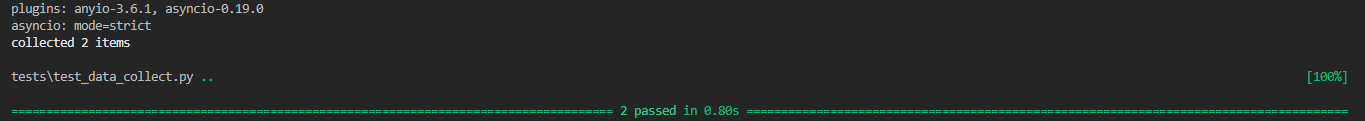

In [ ]:
class AsyncIteratorMock:
    def __init__(self, data):
        self.iter = iter(data)

    def __aiter__(self):
        return self

    async def __anext__(self):
        try:
            return next(self.iter)
        except StopIteration:
            raise StopAsyncIteration

# Traitement IA
Nous allons maintenant rajouter un traitement sur ces données, pour les clusteriser et obtenir des **sessions d'interactions**, delimités par un debut et une fin, plutot que d'avoir la donnée brut plus difficile à interpréter. Nous utiliserons l'algorithme [hdbscan](http://vulgairedev.fr/blog/article/clustering-hdbscan).

```
poetry add joblib==1.1.0 hdbscan
```
NB: Au moment d'écriture de ce notebook, il y a y un conflit entre joblib et hdbscan sous windows, il faut donc [specifier une version anterieure](https://stackoverflow.com/questions/73830225/init-got-an-unexpected-keyword-argument-cachedir-when-importing-top2vec)

Cette fois-ci commençons par écrire le test d'abord :

In [ ]:
# test_compute_sessions.py
from tp_fast_api.compute_sessions import compute_sessions

 
def test_compute_sessions():
    data = [
       ["1", "romain", "instance"], 
       ["2", "romain", "instance"], 
       ["6", "romain", "instance"], 
       ["10", "romain", "instance"], 
       ["12", "romain", "instance"], 
       ["13", "romain", "instance"], 
       ["18", "anes", "instance"],
       ["19", "anes", "instance"] 
    ]

    data_cluster = compute_sessions(data)
    assert len(data_cluster) == 2

On va maintenant ecrire la fonction qui, pour une liste de données telle que retournée par extract_ecrans_async(), va nous clusteriser les données, et nous retourner une liste de dictionnaires, ayant chacun un debut, une fin, une instance et une personne.

In [ ]:
# compute_sessions.py
import pandas as pd
import hdbscan

import tp_fast_api.settings as settings


def compute_sessions(data: list[list]) -> pd.DataFrame:
    df = pd.DataFrame(
        data=data,
        columns=["@timestamp", "personne", "instance"],
    )

    clusterer = hdbscan.HDBSCAN(min_cluster_size=settings.CLUSTER_MIN_POINTS)

    windows = []
    for _, group in df.groupby("personne"):
        # hdbscan pour un seul point semble nous mettre une erreur
        if len(group) > 1:
            group["cluster"] = clusterer.fit_predict(
                group["@timestamp"].array.reshape(-1, 1)
            )
        else:
            group["cluster"] = -1

        group = group[group["cluster"] >= 0]  # on supprime le bruit
        for _, cluster_group in group.groupby("cluster"):
            new_data = {
                "debut": cluster_group["@timestamp"].min(),
                "fin": cluster_group["@timestamp"].max(),
                "instance": cluster_group.at[cluster_group.index[0], "instance"],
                "personne": cluster_group.at[cluster_group.index[0], "personne"],
            }
            windows.append(new_data)

    return windows

Plus qu'à mettre à jour main_async:

In [ ]:
# main_async.py
from datetime import datetime

from fastapi import FastAPI
from pydantic import BaseModel

from tp_fast_api.data_collect import extract_ecrans_async
from tp_fast_api.compute_sessions import compute_sessions

class Users(BaseModel):
    utils: list[str]
    date_min: datetime
    date_max: datetime


app = FastAPI(debug=True)


@app.post("/get_ecrans/")
async def get_ecrans(users: Users):
    ecrans = await extract_ecrans_async(users.utils, users.date_min, users.date_max)
    sessions = compute_sessions(ecrans)
    return {"session": sessions}

Et on obtient bien un **service qui nous permet, pour des parametres spécifiés, d'obtenir une donnée raffinée, mieux exploitable pour le metier**. On pourrait ensuite faire une dataviz avec, calculer d'autres métriques à partir de cette information, etc.  
Pour la mise en production, plusieurs possibilités, voir la doc de [fastAPI](https://fastapi.tiangolo.com/deployment/) 

# Gestion du format de sortie
Pour finir, on va specifier grâce à pydantic le format de sortie, qui nous permettra d'eviter les erreurs de convertion de type dans la construction de la reponse, ainsi que mieux documenter notre api:

In [ ]:
# main_async
from datetime import datetime

from fastapi import FastAPI
from pydantic import BaseModel

from tp_fast_api.data_collect import extract_ecrans, extract_ecrans_async
from tp_fast_api.compute_sessions import compute_sessions

app = FastAPI(debug=True)


class Users(BaseModel):
    utils: list[str]
    date_min: datetime
    date_max: datetime


class Session(BaseModel):
    debut: datetime
    fin: datetime
    instance: str
    personne: str


class OutResponse(BaseModel):
    sessions: list[Session]


@app.post("/get_ecrans/", response_model=OutResponse) 
async def get_ecrans(users: Users):
    ecrans = await extract_ecrans_async(users.utils, users.date_min, users.date_max)
    sessions = await compute_sessions(ecrans)
    return {"sessions": sessions}

# Typage des données d'elastic

Apres reflexion, on se rend compte que le typage des données qui sortent d'elastic est important lui aussi: sans celui-ci, certains champs texte du type "01" pourront être malencrontreusement transformé en float ou int. 
Pour régler ce probleme, on pourrait utiliser [elasticsearch-dsl](https://elasticsearch-dsl.readthedocs.io/en/latest/), cependant celui-ci ne fonctionne pas en asynchrone.
On peut donc utiliser directement pydantic, par exemple:

In [ ]:
# data_collect.py
from datetime import datetime

from pydantic import BaseModel
from elasticsearch import helpers

import tp_fast_api.settings as settings

class Ecran(BaseModel):
    ecran: str
    instance: str 
    timestamp: datetime
    util: str

    
async def extract_ecrans_async(utils: list[str], date_min: datetime, date_max: datetime):
    query = {
        "query": {
            "bool": {
                "must": [{"terms": {"util": utils}}],
                "filter": [
                    {
                        "range": {
                            "@timestamp": {
                                "gte": date_min.isoformat(),
                                "lte": date_max.isoformat(),
                                "format": "strict_date_optional_time",
                            }
                        }
                    }
                ],
            }
        }
    }

    data = []
    async for doc in helpers.async_scan(settings.ES_ASYNC, index="mon_index", query=query):
        doc = doc["_source"]
        doc_parsed = Ecran(**doc, timestamp=doc["@timestamp"])
        elt = [
            doc_parsed.ecran,
            doc_parsed.timestamp,
            doc_parsed.util,
            doc_parsed.instance,
        ]
        data.append(elt)

    return data

NB: pour être plus propre, mieux vaut mettre les modeles de données pydantic à part dans un module modeles.py